In [1]:
import torch
import os
import numpy as np

import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import pandas as pd
import matplotlib.pyplot as plt

from model.classifier import Net as ClassNet

trained_class = './result/eta50_gpu_classification_g3train.pt'
class_model = ClassNet()
class_model.load_state_dict(torch.load(trained_class, map_location=torch.device('cpu')))
class_model.eval()
class_model = class_model.double()

print("Model Loaded")

print("Importing Data")

/tmpscratch/tkim12/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Loaded
Importing Data


In [2]:
file_loc = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

# Load background
bkg_file = 2
CMB_bkg = []
for file_num in range(bkg_file):
    Xtemp = np.load(file_loc+"quicklens_backgound/500_events_90Sqr_lensed_Backgroundlmax3500_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_bkg.append(Xtemp[k])


# Load CMB signal only (g = 1)
CMB_sig = []
for file_num in range(1,3):
    Xtemp = np.load(file_loc+"PHS_signal/500_eta50PHS_g1_Sig_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_sig.append(Xtemp[k])

In [3]:
CMB_bkg = np.array(CMB_bkg)
CMB_sig = np.array(CMB_sig)


CMB_bkg1 = np.array(random.choices(CMB_bkg, k=5))

rescale_g = np.array([2, 2.3, 2.7, 3, 4])

implated_sig = rescale_g[3]*np.array(random.choices(CMB_sig, k=5))

CMB_bkgsig = CMB_bkg1 + implated_sig


CMB_bkg1_num = CMB_bkg1.shape[0]


Y_bkg = np.zeros(CMB_bkg1_num)
Y_sig = np.ones(CMB_bkg1_num)

wid, hei = CMB_bkg1.shape[1], CMB_bkg1.shape[2]
print(CMB_bkg1.shape[0], wid, hei)

CMB_bkg1 = CMB_bkg1.reshape(CMB_bkg1.shape[0], 1, wid, hei).astype('float64')
CMB_bkg1 = torch.from_numpy(CMB_bkg1)

CMB_bkgsig = CMB_bkgsig.reshape(CMB_bkgsig.shape[0], 1, wid, hei).astype('float64')
CMB_bkgsig = torch.from_numpy(CMB_bkgsig)


Y_bkg = Y_bkg.reshape(Y_bkg.shape[0], 1).astype('float64')
Y_bkg = torch.from_numpy(Y_bkg)
Y_sig = Y_sig.reshape(Y_sig.shape[0], 1).astype('float64')
Y_sig = torch.from_numpy(Y_sig)

5 90 90


In [4]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

bkg1_data = TensorDataset(CMB_bkg1, Y_bkg)
bkgsig_data = TensorDataset(CMB_bkgsig, Y_sig)

bkg1loader = DataLoader(dataset=bkg1_data, batch_size=1, shuffle=False)
bkgsigloader = DataLoader(dataset=bkgsig_data, batch_size=1, shuffle=False)

In [5]:
class_model

Net(
  (conv1): Conv2d(1, 8, kernel_size=(16, 16), stride=(2, 2), padding=(7, 7))
  (conv2): Conv2d(8, 8, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (avepool): AvgPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0)
  (fc1): Linear(in_features=128, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fin): Linear(in_features=200, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [6]:
print("Prediction ... ")

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


layer2look = 'conv3'
class_model.conv3.register_forward_hook(get_activation(layer2look))

i=0

class_model = class_model.double()

sig_outputs = []
bkg_outputs = []

conv1_sig = []
conv1_bkg = []

with torch.no_grad():
    for data in bkg1loader:
        i+=1
        images, y = data
        coutputs = class_model(images)
        
        print(coutputs,y)
        
        if y[0][0].numpy()==0:
            bkg_outputs.append(coutputs.detach().numpy())
            conv1_bkg.append(activation[layer2look].detach().numpy())
            
        elif y[0][0].numpy()==1:
            sig_outputs.append(coutputs.detach().numpy())
            conv1_sig.append(activation[layer2look].detach().numpy())

        if i%100==0:
            print("Event : "+str(i)+" Completed")



with torch.no_grad():
    for data in bkgsigloader:
        i+=1
        images, y = data
        coutputs = class_model(images)
        
        print(coutputs,y)
        
        if y[0][0].numpy()==0:
            bkg_outputs.append(coutputs.detach().numpy())
            conv1_bkg.append(activation[layer2look].detach().numpy())
            
        elif y[0][0].numpy()==1:
            sig_outputs.append(coutputs.detach().numpy())
            conv1_sig.append(activation[layer2look].detach().numpy())

        if i%100==0:
            print("Event : "+str(i)+" Completed")

Prediction ... 
tensor([[0.0259]], dtype=torch.float64) tensor([[0.]], dtype=torch.float64)
tensor([[0.0006]], dtype=torch.float64) tensor([[0.]], dtype=torch.float64)
tensor([[0.0004]], dtype=torch.float64) tensor([[0.]], dtype=torch.float64)
tensor([[6.5701e-06]], dtype=torch.float64) tensor([[0.]], dtype=torch.float64)
tensor([[0.0602]], dtype=torch.float64) tensor([[0.]], dtype=torch.float64)
tensor([[1.]], dtype=torch.float64) tensor([[1.]], dtype=torch.float64)
tensor([[1.0000]], dtype=torch.float64) tensor([[1.]], dtype=torch.float64)
tensor([[1.]], dtype=torch.float64) tensor([[1.]], dtype=torch.float64)
tensor([[1.]], dtype=torch.float64) tensor([[1.]], dtype=torch.float64)
tensor([[1.]], dtype=torch.float64) tensor([[1.]], dtype=torch.float64)


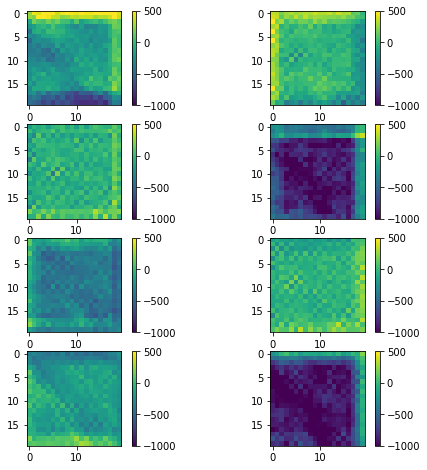

In [46]:
fig = plt.figure(figsize=(8, 8))

event_number = 4

columns = 2
rows = 4

for i in range(1, 9):
    img = conv1_bkg[event_number][0][i-1]
    #img = conv1_bkg[0][0][i-1]
    #print(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.clim(-10**3,5*10**2)
    plt.colorbar()
fig.savefig('./hidden_layer/eta50_bkgconv3_hidden_layer_'+str(event_number)+'.pdf',dpi=90, bbox_inches='tight')

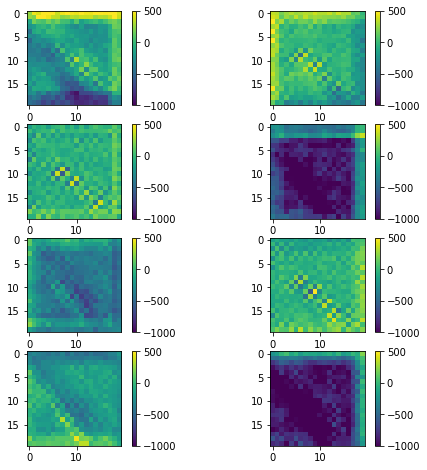

In [47]:
fig = plt.figure(figsize=(8, 8))

columns = 2
rows = 4

for i in range(1, 9):
    img = conv1_sig[event_number][0][i-1]
    #img = conv1_bkg[0][0][i-1]
    #print(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.clim(-10**3,5*10**2)
    plt.colorbar()
fig.savefig('./hidden_layer/eta50_sigconv3_hidden_layer_'+str(event_number)+'.pdf',dpi=90, bbox_inches='tight')

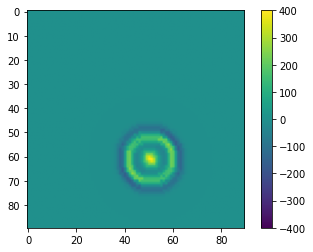

In [48]:
plt.imshow(15*implated_sig[event_number])
plt.clim(-400,400)
plt.colorbar()
plt.savefig('./hidden_layer/eta50_true_'+str(event_number)+'.pdf',dpi=90, bbox_inches='tight')

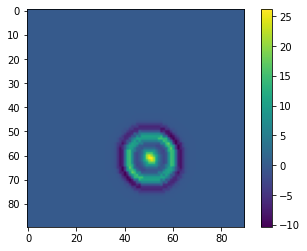

In [49]:
plt.imshow(implated_sig[event_number])
#plt.clim(-400,400)
plt.colorbar()
plt.savefig('./hidden_layer/eta50_true_'+str(event_number)+'_2.pdf',dpi=90, bbox_inches='tight')

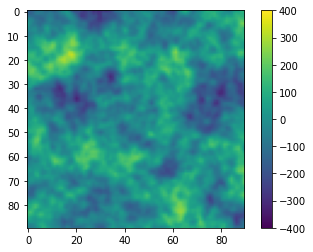

In [50]:
plt.imshow(CMB_bkg1[event_number,0])
plt.clim(-400,400)
plt.colorbar()
plt.savefig('./hidden_layer/eta50_pure_bkg_'+str(event_number)+'.pdf',dpi=90, bbox_inches='tight')

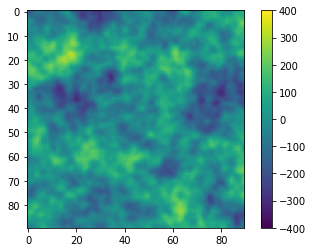

In [51]:
plt.imshow(CMB_bkgsig[event_number,0])
plt.clim(-400,400)
plt.colorbar()
plt.savefig('./hidden_layer/eta50_sig_bkg_'+str(event_number)+'.pdf',dpi=90, bbox_inches='tight')

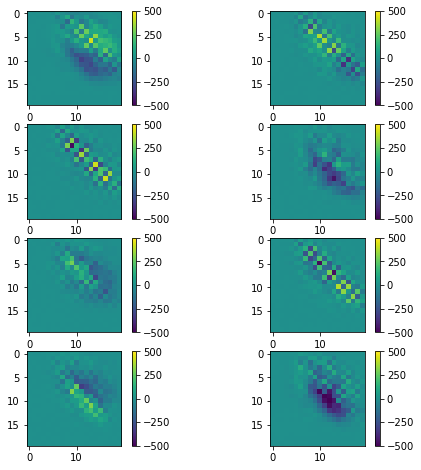

In [27]:
fig = plt.figure(figsize=(8, 8))

columns = 2
rows = 4

for i in range(1, 9):
    imgbk = conv1_bkg[event_number][0][i-1]
    imgsig = conv1_sig[event_number][0][i-1]
    
    img = imgsig-imgbk
    #img = conv1_bkg[0][0][i-1]
    #print(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.clim(-5*10**2,5*10**2)
    plt.colorbar()